In [ ]:
# automatically reload edited source code
%load_ext autoreload
%autoreload 2

# external package imports
import numpy as np
import pandas as pd
import os, pdb, glob, time, argparse
from os.path import exists, split, isdir, getsize
from sdo_clv_pipeline.sdo_plot import *

# internal package imports
from sdo_clv_pipeline.paths import root
from sdo_clv_pipeline.sdo_io import *
from sdo_clv_pipeline.sdo_process import *
from sdo_clv_pipeline.sdo_io import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preliminaries
First we need to find our files and then read them in. They are plain FITS files that can be read with astropy or sunpy, but I wrote some extra code to help parse out the data for our purposes. If you're curious, you can look in ```sdo_image.py```

In [ ]:
# define the paths where files live
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
con_file = os.path.join(data_dir, "hmi.Ic_720s.20140107_000000_TAI.continuum.fits")
mag_file = os.path.join(data_dir, "hmi.M_720s.20140107_000000_TAI.magnetogram.fits")
dop_file = os.path.join(data_dir, "hmi.V_720s.20140107_000000_TAI.Dopplergram.fits")
aia_file = os.path.join(data_dir, "aia_lev1_1700a_2014_01_07t00_00_30_71z_image_lev1.fits")

/Users/srugins/sdo-clv-pipeline/data


In [ ]:
# create the SDOImage object instances
con = SDOImage(con_file)     # continuum, Relative HMI continuum intensity
mag = SDOImage(mag_file)     # magnetogram, magnetic field strength
dop = SDOImage(dop_file)     # Dopplergram, LOS velocity
aia = SDOImage(aia_file)     # AIA 1700 continuum filtergram, Relative 1700 Angstrom Continuum Intensity

In [231]:
aia.image

array([[ 3.,  3., -2., ..., -1.,  4., -1.],
       [ 3.,  2.,  3., ..., -1., -1., -1.],
       [-3., -3., -3., ..., -1., -1., -1.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ..., -4.,  0.,  0.],
       [-4.,  0.,  0., ...,  0.,  1.,  0.]],
      shape=(4096, 4096), dtype=float32)

## Initial Processing
Next we need figure out the coordinates of our images and "correct" for some physical effects. Initially our images are all in pixel coordinates, but the FITS header has the information we need to transform from pixel coordinates to a heliophysical coordinate systems. If you want to go down the rabit whole of coordinate systems, you can look here: https://www.aanda.org/articles/aa/pdf/2006/14/aa4262-05.pdf

In [232]:
# do the coordinate transforms, etc.
dop.calc_geometry()
con.inherit_geometry(dop)
mag.inherit_geometry(dop)

In [233]:
aia.rescale_to_hmi(con) # reporject onto plate scale of HMI images

In [234]:
# calculate the limb darkening correction
con.calc_limb_darkening()
aia.calc_limb_darkening()

In [235]:
# correct magnetogram for foreshortening
mag.correct_magnetogram()

In [236]:
# calculate differential rot., meridional circ., obs. vel, grav. redshift, cbs
dop.correct_dopplergram(fit_cbs=False)

In [237]:
# set values to nan for mu less than mu_thresh
mu_thresh = 0.1
con.mask_low_mu(mu_thresh)
dop.mask_low_mu(mu_thresh)
mag.mask_low_mu(mu_thresh)
aia.mask_low_mu(mu_thresh)

## Identifying Pixels
The ```SunMask``` constructor performs the task of indentifying pixels. You'll be playing with/augmenting the code in this function! 

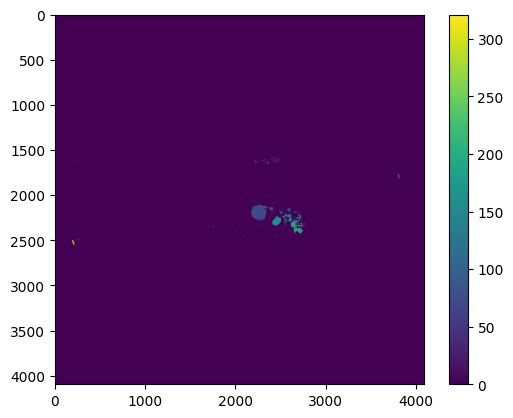

5278.0
0.952248
1263.0
0.38659573
22953.0
0.9898266
1374.0
0.98114824
1112.0
0.95611614
3007.0
0.95245016
6942.0
0.9678753
8772.0
0.9308501
(8, 103)
trying to plot...


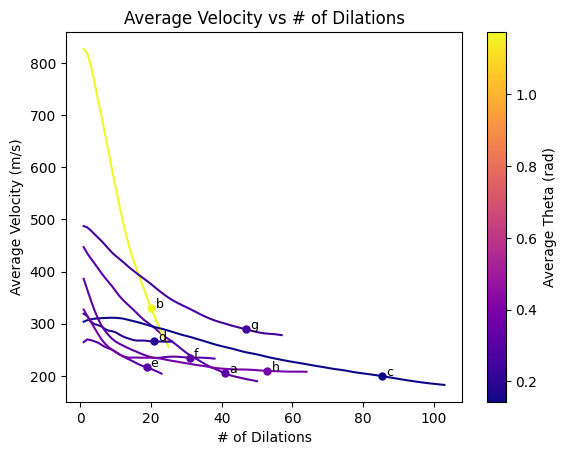

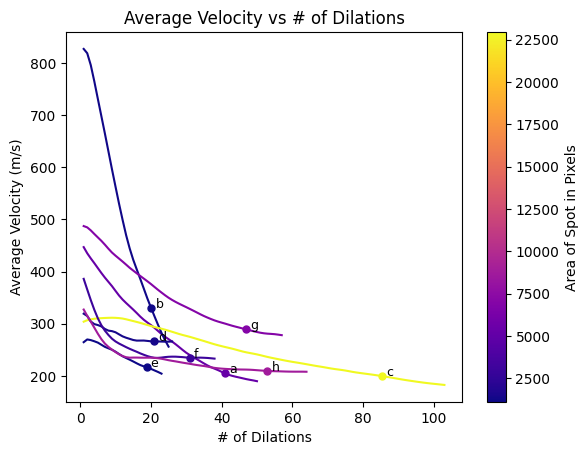

trying to plot...


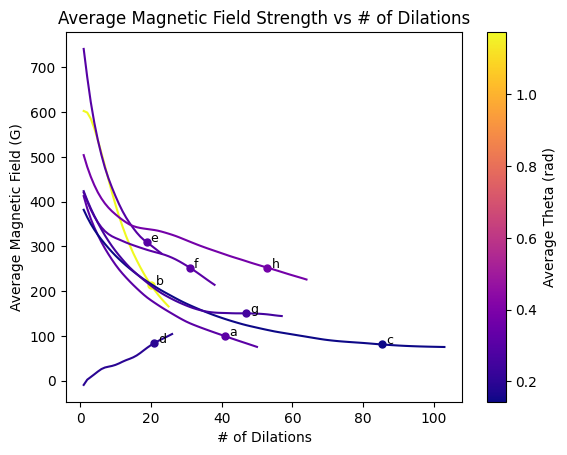

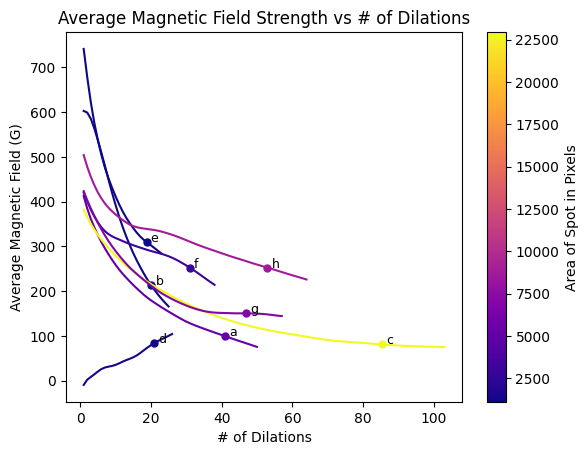

trying to plot...


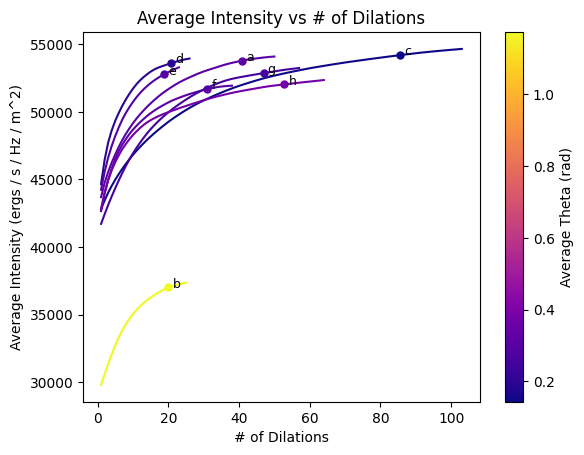

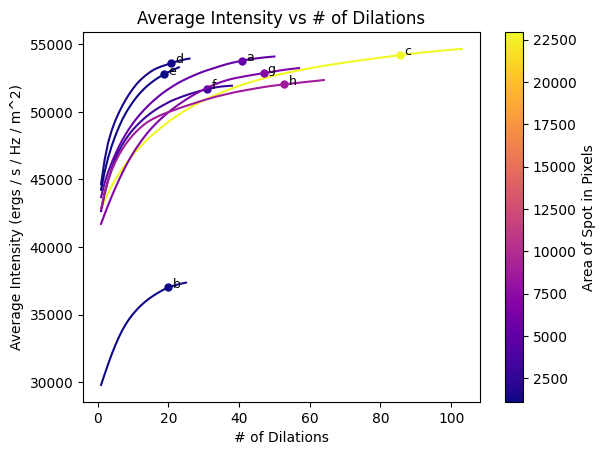

In [322]:
mask = SunMask(con, mag, dop, aia)
mask.mask_low_mu(mu_thresh)

## Plotting
I have some plotting code that you can use to visualize the images we processed

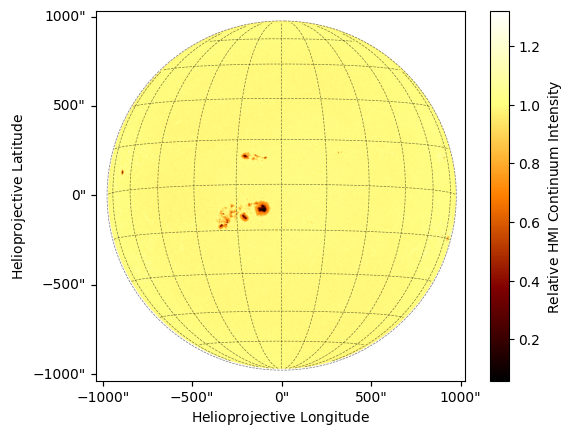

In [239]:
plot_image(con)

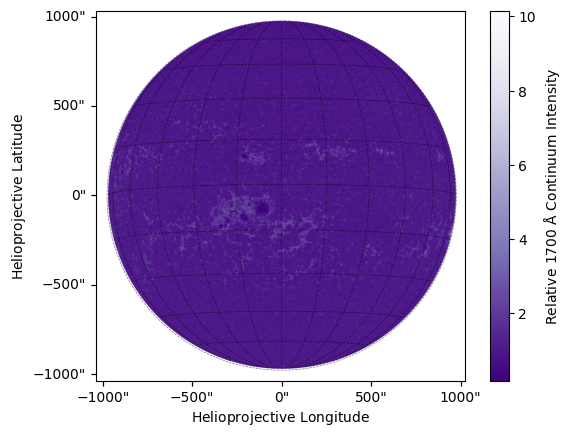

In [240]:
plot_image(aia)

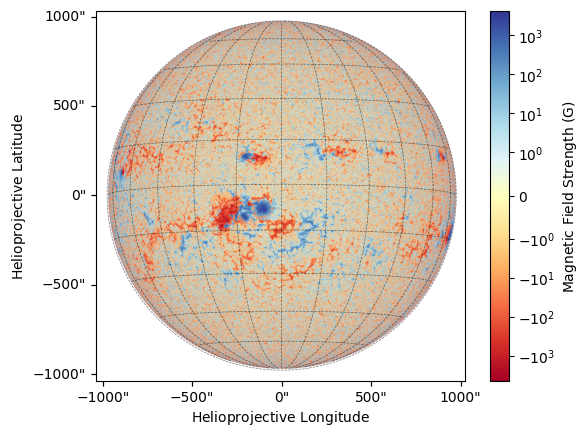

In [241]:
plot_image(mag)

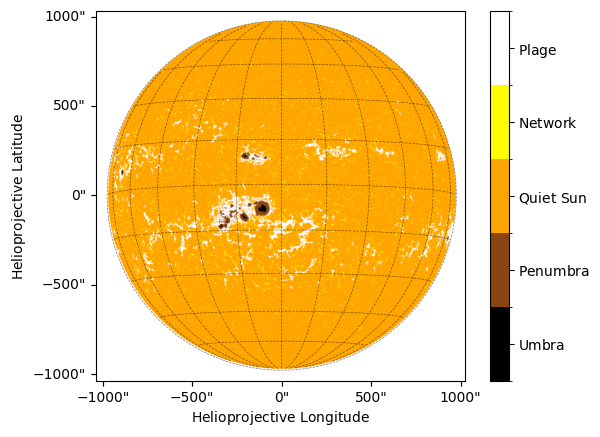

In [242]:
plot_mask(mask)

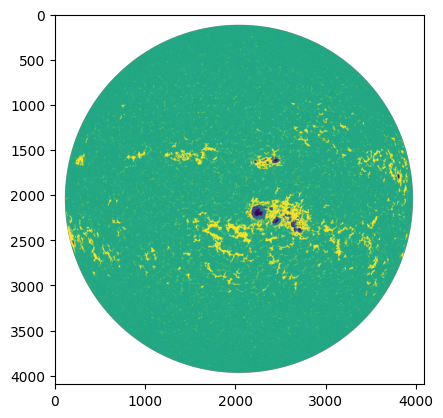

In [243]:
plt.imshow(mask.regions)

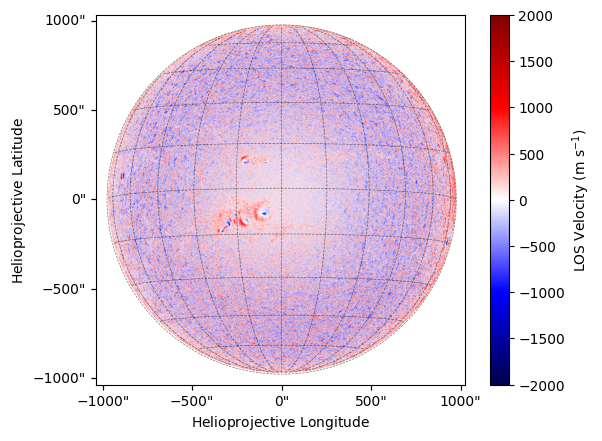

In [244]:
plot_image(dop)

In [245]:
np.unique(mask.regions)

array([ 1.,  2.,  3.,  4.,  5.,  6., nan], dtype=float32)

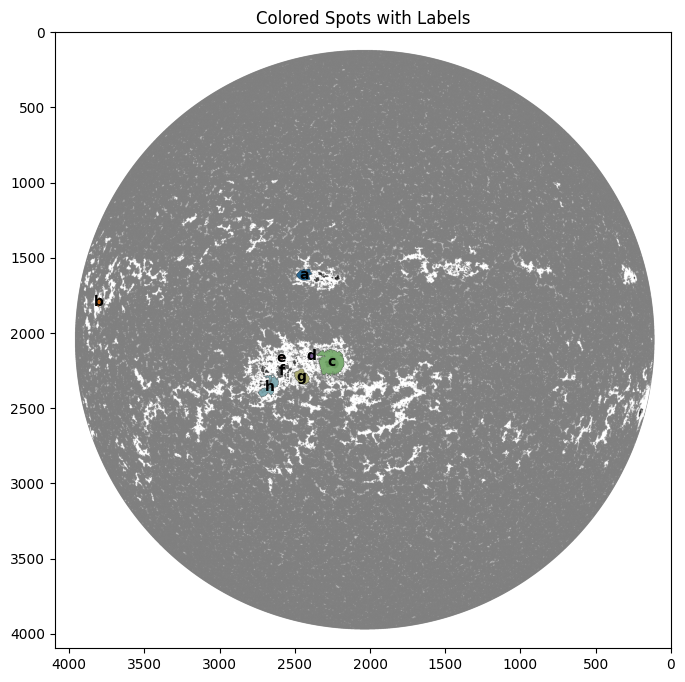

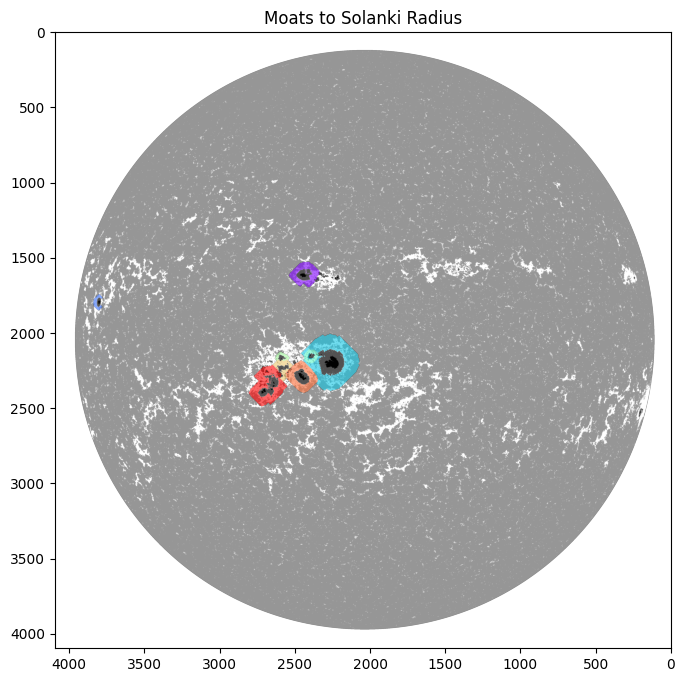

In [323]:
label_moats_on_sun(mask)